
В файле data.csv (находится в архиве "Вспомогательный данные") представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

Например, если бы мы знали будущее объема расчетных счетов, как на рисунке 1 (находится в архиве "Вспомогательный данные"), то стабильная часть на 1 месяц (1м) была бы на уровне, обозначенным красным цветом. Это тот уровень, который не пробивается на протяжении 1 месяца. Аналогично 2м – зеленый, 3м – синий, 4м – розовый.

Для временного ряда в файле data.csv необходимо построить модель, которая оценивает обьем стабильной части средств на дату.

Например:

model_forecast

(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М

Возможные горизонты: 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М

Критерии качества модели:

Нужно одновременно минимизировать величины:

максимальный объем пробития стабильный части на валидационной выборке
фактическая стабильная часть – модельная стабильная часть
Можно применять любые подходы. Как вариант: построить квантильную регрессию для прогнозирования ряда.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from dateutil.relativedelta import relativedelta
from datetime import datetime

from sklearn.linear_model import LinearRegression
import xgboost as xgb

%matplotlib inline

In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

In [ ]:
cd '/content/sample_data/'

/content/sample_data


In [ ]:
data = pd.read_csv('data.csv', sep=';', parse_dates=[0], dayfirst=True)
data.head()

,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149


In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature

    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
def split_on_train_test(data, date, period):
    """Делит датасет на обучающую и валидационную выборки"""
    period = int(period.split('M')[0])
    start_predict = datetime.strptime(date, '%Y-%m-%d')
    end_predict = start_predict + relativedelta(months=+period)

    X_train = data[(data.index < start_predict)].drop(['VALUE'], axis=1).fillna(0).reset_index()

    y_train = data[(data.index < start_predict)]['VALUE']

    X_test = data[(data.index >= start_predict) & 
                  (data.index <= end_predict)].drop(['VALUE'], axis=1).fillna(0).reset_index()

    y_test = data[(data.index >= start_predict) & 
                  (data.index <= end_predict)]['VALUE']

    return X_train, y_train, X_test, y_test

In [ ]:
def prepareData(dataframe, date, period, lag_start=1, lag_end=40):
    """Добавляет фичи и готовит данных для модели"""
    dt = pd.DataFrame(dataframe['VALUE'])
    start_predict = datetime.strptime(date, '%Y-%m-%d')

    # добавляем лаги исходного ряда как признаки
    for i in range(lag_start, lag_end):  
        dt["lag_{}".format(i)] = dt.VALUE.shift(i)
    
    dt.index = dataframe['REPORTDATE']
    dt["weekday"] = dt.index.weekday
    dt['is_weekend'] = dt.weekday.isin([5,6]) * 1

    # считаем средние только по тренировочной части, чтобы избежать лика
    dt_train = dt[dt.index < start_predict]
    dt_mean_on_weekday = code_mean(dt_train, 'weekday', 'VALUE')
    dt["weekday_average"] = list(map(dt_mean_on_weekday.get, dt['weekday']))

    # выкидываем закодированные средними признаки 
    dt.drop(["weekday"], axis=1, inplace=True)

    return dt

# Предварительный анализ

In [ ]:
data.shape

(2111, 2)

In [ ]:
data.head()

,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149


In [ ]:
data['REPORTDATE'].max()

Timestamp('2019-10-10 00:00:00')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   REPORTDATE  2111 non-null   datetime64[ns]
 1   VALUE       2111 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


In [ ]:
len(np.unique(data['REPORTDATE'].values))

2111

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VALUE,2111.0,3.389668e+10,1.875474e+10,3.282810e+09,1.824160e+10,3.021352e+10,4.758339e+10,7.822860e+10


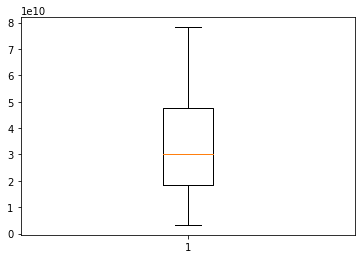

In [ ]:
plt.boxplot(data['VALUE']);

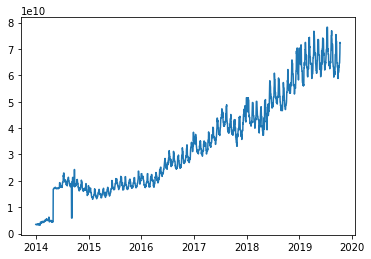

In [ ]:
plt.plot(data['REPORTDATE'], data['VALUE']);

Посмотрим на графики по годам, исключив 2013, тк там только 2 точки.

In [ ]:
all_years = set(data['REPORTDATE'].dt.year) - {2013}
all_years

{2014, 2015, 2016, 2017, 2018, 2019}

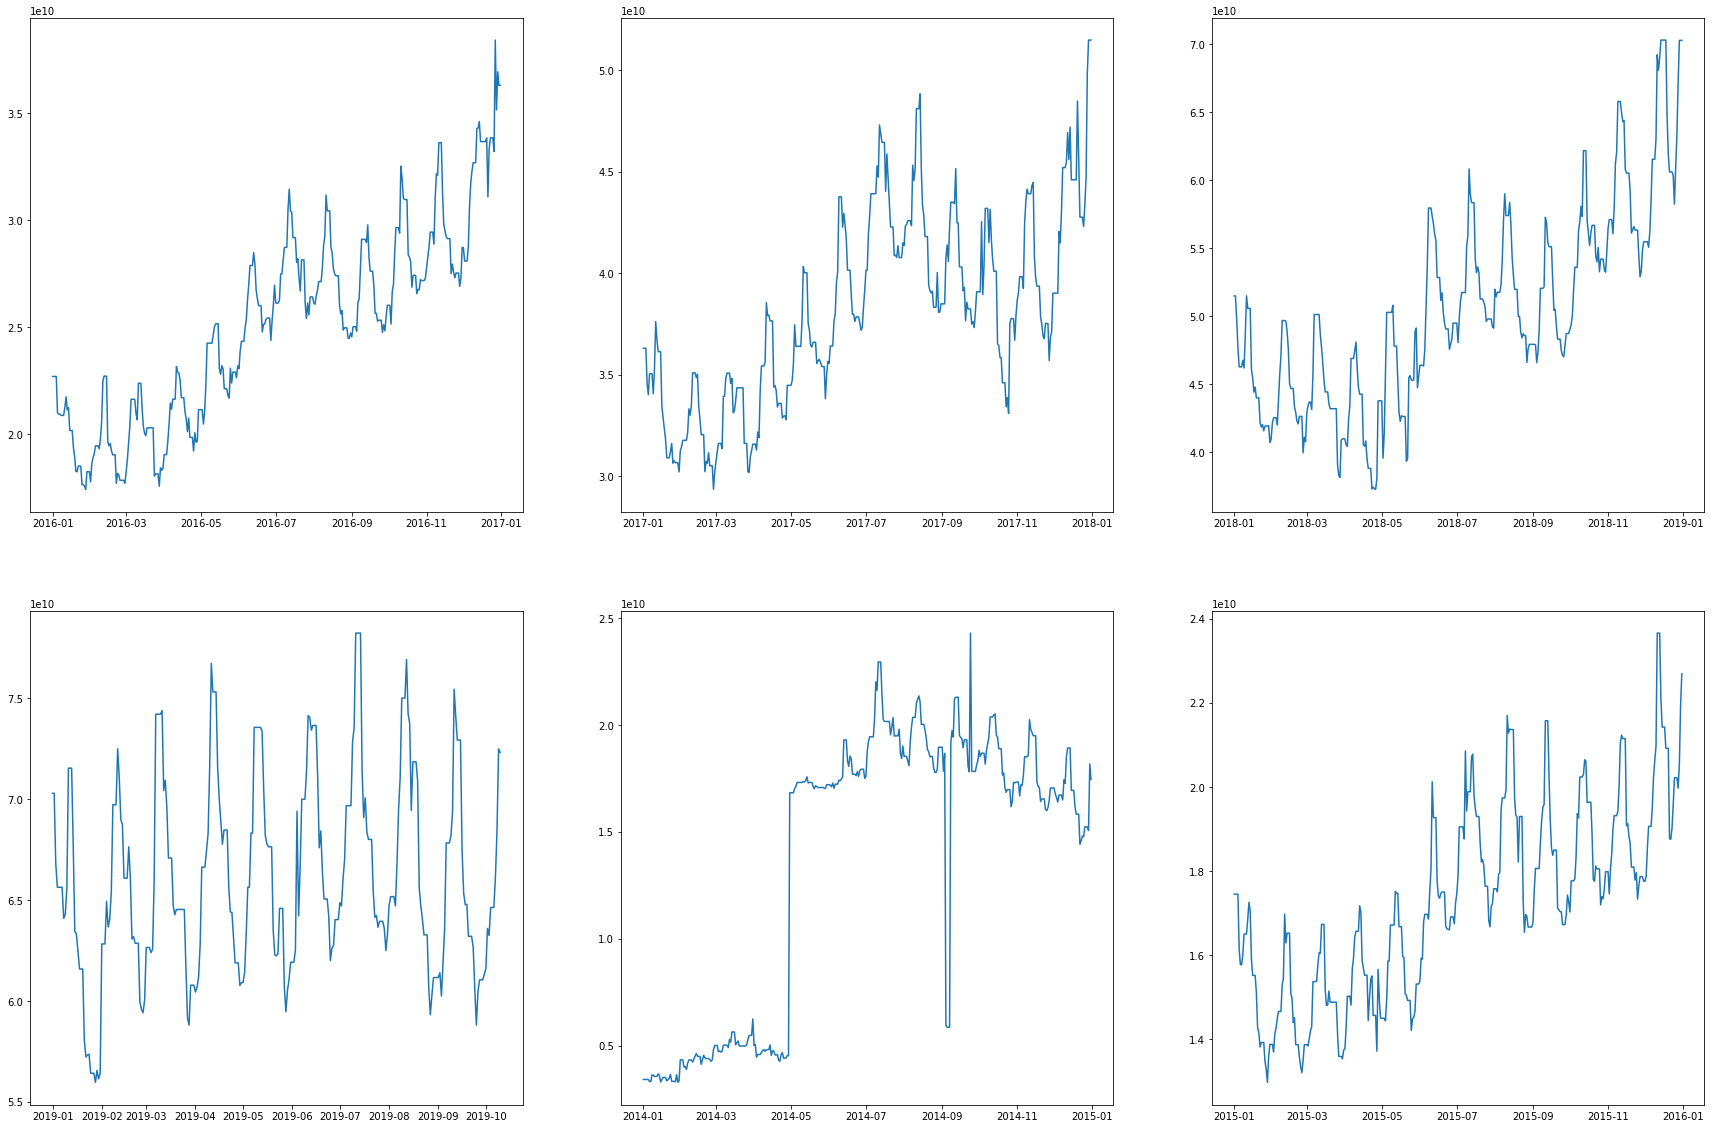

In [ ]:
def draw_line(ax, x, y):
    ax.plot(x, y)

dt_year = [data[data['REPORTDATE'].dt.year == year] for year in all_years]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))

for i, ax in enumerate(axes.flatten()):
    draw_line(ax, dt_year[i]['REPORTDATE'], dt_year[i]['VALUE']) 

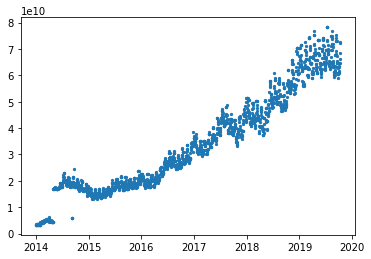

In [ ]:
plt.scatter(data['REPORTDATE'], data['VALUE'], s=5);

# Линейная регрессия

In [ ]:
data.tail(50).iloc[0]

REPORTDATE    2019-08-22 00:00:00
VALUE                 64052195911
Name: 2061, dtype: object

In [ ]:
data.tail()

,REPORTDATE,VALUE
2106,2019-10-06,64630140507
2107,2019-10-07,66115288637
2108,2019-10-08,68424049766
2109,2019-10-09,72492897583
2110,2019-10-10,72307860851


In [ ]:
per = '12M'
start_date = '2018-10-10'
dataframe = prepareData(data, start_date, per, lag_start=1, lag_end=30)
X_train, y_train, X_test, y_test = split_on_train_test(dataframe, start_date, per)

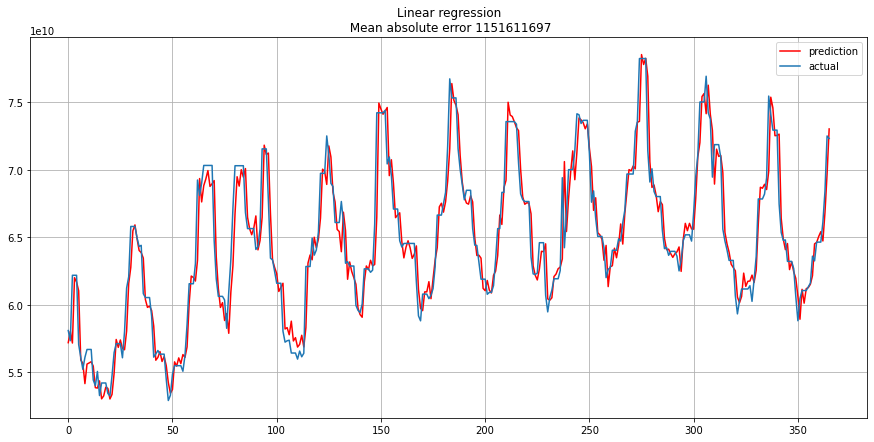

In [ ]:
lr = LinearRegression()
lr.fit(X_train.drop(['REPORTDATE'], axis=1), y_train)
prediction = lr.predict(X_test.drop(['REPORTDATE'], axis=1))
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [ ]:
len(prediction)

366

In [ ]:
X_test['REPORTDATE']

0     2018-10-10
1     2018-10-11
2     2018-10-12
3     2018-10-13
4     2018-10-14
         ...    
361   2019-10-06
362   2019-10-07
363   2019-10-08
364   2019-10-09
365   2019-10-10
Name: REPORTDATE, Length: 366, dtype: datetime64[ns]

In [ ]:
print(*[int(x) for x in prediction[:5]], sep='\n')

57182470152
58025929406
57156561905
61994788554
61670681689


In [ ]:
y_test.iloc[:5]

REPORTDATE
2018-10-10    58080499468
2018-10-11    57329035606
2018-10-12    62173977750
2018-10-13    62173977750
2018-10-14    62173977750
Name: VALUE, dtype: int64

# xgboost

In [ ]:
per = '12M'
start_date = '2018-10-10'
dataframe = prepareData(data, start_date, per, lag_start=1, lag_end=30)
X_train, y_train, X_test, y_test = split_on_train_test(dataframe, start_date, per)

In [ ]:
dtrain = xgb.DMatrix(X_train.drop(['REPORTDATE'], axis=1), label=y_train)
dtest = xgb.DMatrix(X_test.drop(['REPORTDATE'], axis=1))

In [ ]:
# задаём параметры
params = {
    'objective': 'reg:linear',
    'booster': 'gblinear'
}
trees = 3000

In [ ]:
# прогоняем на кросс-валидации с метрикой rmse
cv = xgb.cv(params, dtrain, metrics=('rmse'), verbose_eval=False, 
            nfold=10, show_stdv=False, num_boost_round=trees)

[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

[18:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# запоминаем ошибку на кросс-валидации
deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

In [ ]:
deviation  # 1088013926.4

1088094099.2

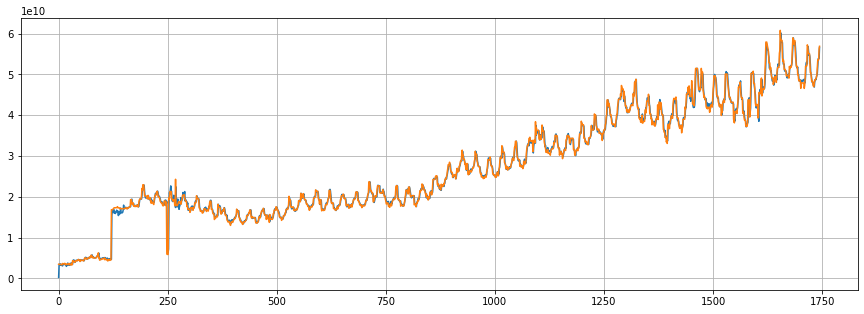

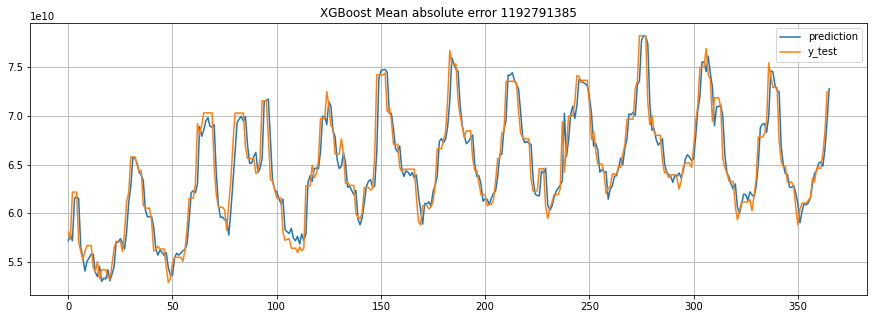

In [ ]:
# посмотрим, как модель вела себя на тренировочном отрезке ряда 
scale=1.96 

prediction_train = bst.predict(dtrain)
plt.figure(figsize=(15, 5))
plt.plot(prediction_train)
plt.plot(y_train.values)
plt.axis('tight')
plt.grid(True)

# и на тестовом
prediction_test = bst.predict(dtest)
lower = prediction_test - scale*deviation
upper = prediction_test + scale*deviation

plt.figure(figsize=(15, 5))
plt.plot(prediction_test, label="prediction")
plt.plot(list(y_test), label="y_test")
plt.legend(loc="best")
plt.axis('tight')
plt.title("XGBoost Mean absolute error {}".format(round(mean_absolute_error(prediction_test, y_test))))
plt.grid(True)
plt.legend();

In [ ]:
print(*[int(x) for x in prediction_test[:5]], sep='\n')  # xgboost

57202733056
57859948544
57184956416
61511729152
61709451264


In [ ]:
y_test.iloc[:5]

REPORTDATE
2018-10-10    58080499468
2018-10-11    57329035606
2018-10-12    62173977750
2018-10-13    62173977750
2018-10-14    62173977750
Name: VALUE, dtype: int64

In [ ]:
print(*[int(x) for x in prediction[:5]], sep='\n')  # лин рег

57182470152
58025929406
57156561905
61994788554
61670681689


In [ ]:
per = '2M'
start_date = '2018-10-10'
dataframe = prepareData(data, start_date, per, lag_start=1, lag_end=30)
X_train, y_train, X_test, y_test = split_on_train_test(dataframe, start_date, per)

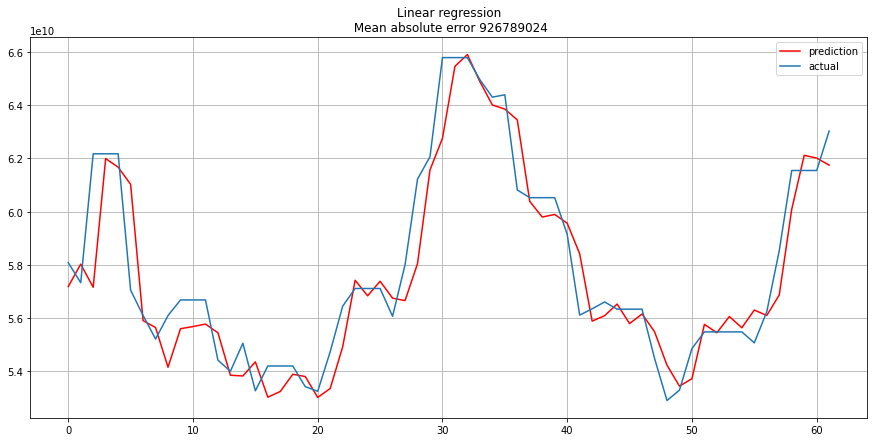

In [ ]:
lr = LinearRegression()
lr.fit(X_train.drop(['REPORTDATE'], axis=1), y_train)
prediction = lr.predict(X_test.drop(['REPORTDATE'], axis=1))
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);